<a href="https://colab.research.google.com/github/maoroh/keras-frcnn/blob/master/CountingCars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating workspace : clone on GitHub, downloading CARPK dataset and unzip it, then downloading the final model.**

In [0]:
#Clone into GitHub repo 
!git clone https://github.com/maoroh/keras-frcnn.git
%cd /content/keras-frcnn
!wget http://139.59.179.174/CARPK_devkit.zip
!unzip CARPK_devkit.zip -d dataset/
%mkdir model
#Download the final keras weights file after training
!wget http://139.59.179.174/cars_last_model.hdf5 -O model/cars_last_model.hdf5
#Download the basenet weights file fro ResNet50
!wget http://139.59.179.174/resnet50_weights_tf_dim_ordering_tf_kernels.h5 -O model/resnet50_weights_tf_dim_ordering_tf_kernels.h5



In [0]:
%cd /content/keras-frcnn

Clone git repository and download dataset and other files that needed.

**Install Keras 2.0.3 instead of 2.2.4 - For compatibilty reasons**

In [0]:
!pip install keras==2.0.3

**Generate the annotations file from CARPK dataset**

In [0]:
from annotation_generator import AnnotationFileGenerator
from image_dict_creator import ImagesDictCreator
import cv2


parser = AnnotationFileGenerator(path_to_annotations_folder = './dataset/CARPK_devkit/data/Annotations',images_path = './dataset/CARPK_devkit/data/Images/',train_file_path = './dataset/CARPK_devkit/data/ImageSets/train.txt',output_file_path='train.txt')
parser.generate()
print ('Annotation file saved in!')
imagesDictionary = ImagesDictCreator(path_to_dataset_folder='./dataset/CARPK_devkit/data')
images_dict = imagesDictionary.parseAll()
print(images_dict)
print ('Dictionary created!')



**Training Phase **- Don't run it because the model is ready and the file is cars_last_model.hdf5. 

In [0]:
!python train.py


**Test Phase - Calc MAE And RMSE** 

In [0]:
from detector import FasterRCNNDetector
import cv2
import math

def main():
    #Init varaibles for MAE and RMSE
    MAE = 0.0
    RMSE = 0.0
    #Create Detector object
    detector = FasterRCNNDetector(model_path='./model/cars_last_model.hdf5')
    count = 0
    print('Calc MAE and RMSE...')
    for key, value in images_dict.items():
      if value['imageset'] == 'test':
          #Count the test images 
          count = count + 1
          test_predict_count = value['count']
          #Read an Image from the dataset
          img = cv2.imread('./dataset/CARPK_devkit/data/Images/' + key + '.png') 
          #Predict bounding boxes using the detector
          predicted_boxes = detector.detect_on_image(img)
          #get the length of the bounding boxes array
          actual_predict_count = len(predicted_boxes[0])
          #calc the error value
          error = abs(test_predict_count - actual_predict_count)
          #Add the error to the sum
          MAE = MAE + error
          RMSE = RMSE + pow(error,2) 
    
    MAE = MAE / count
    RMSE = math.sqrt((RMSE / count))
    print("MAE is : ")
    print (MAE)
    print("RMSE is : ")
    print (RMSE)


if __name__ == '__main__':
    main()

NOTE: this code only support to keras 2.0.3, newest version this line will got errors. see trace back.
Loading weights from ./model/cars_last_model.hdf5
Calc MAE and RMSE...
MAE is : 
25.437908496732025
RMSE is : 
32.19575203038039


**Test the model on a specific image and show the result.**

NOTE: this code only support to keras 2.0.3, newest version this line will got errors. see trace back.
Loading weights from ./model/cars_last_model.hdf5
Car:
[172. 537. 287. 595.] prob: 0.9994945526123047
[153. 326. 268. 383.] prob: 0.9984397292137146
[268. 326. 364. 364.] prob: 0.9973840117454529
[153. 172. 249. 230.] prob: 0.9972633123397827
[172. 441. 268. 479.] prob: 0.9971428513526917
[499. 364. 614. 403.] prob: 0.996975302696228
[287. 479. 383. 537.] prob: 0.9964852333068848
[153. 383. 249. 441.] prob: 0.9960940480232239
[268. 230. 364. 268.] prob: 0.9959259033203125
[134. 230. 249. 287.] prob: 0.9954190254211426
[499. 211. 595. 249.] prob: 0.9944010376930237
[518. 575. 614. 614.] prob: 0.9939247965812683
[518. 460. 614. 518.] prob: 0.9930949807167053
[710. 326. 787. 403.] prob: 0.9927819967269897
[153. 287. 249. 326.] prob: 0.9926406741142273
[268. 633. 383. 691.] prob: 0.9915643930435181
[499. 422. 614. 460.] prob: 0.9899464249610901
[710. 460. 806. 537.] prob: 0.98619645833969

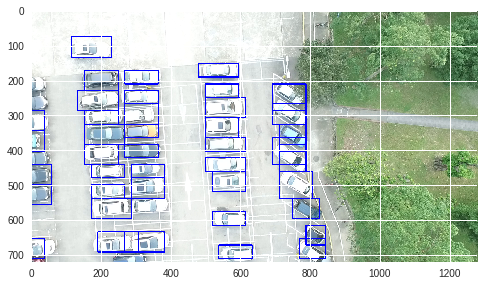

In [0]:


from detector import FasterRCNNDetector
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def main():
    detector = FasterRCNNDetector(model_path='./model/cars_last_model.hdf5')
    img = cv2.imread('./dataset/CARPK_devkit/data/Images/20160331_NTU_00014.png') 
    detector.detect_and_save(img)
    img=mpimg.imread('./results_images/result.png')
    imgplot = plt.imshow(img)
    plt.show()

if __name__ == '__main__':
    main()